### Getting to know the analysis environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

1. **Importing the csv data**

In [ ]:
totalmiles=pd.read_csv('mp1_av_totalmiles.csv')
disengagements=pd.read_csv('mp1_av_disengagements.csv')

In [ ]:
disengagements.head();

In [ ]:
totalmiles.head();

2. **Data Summary**

In [ ]:
# Total number of AV disengagements over entire duration of available data
Total_number_of_AV_disengagements=len(disengagements.index)
Total_number_of_AV_disengagements

1024

In [ ]:
# Number of unique months that have recorded AV disengagements
len(disengagements['Month'].unique())

15

In [ ]:
# List of unique locations of AV disengagements
disengagements['Location'].unique()

array(['urban-street', 'highway'], dtype=object)

In [ ]:
# Number of unique causes for AV disengagements
len(disengagements['Cause'].unique())

10

In [ ]:
# Missing values in the datasets
disengagements.isna().sum()

Month              0
Car                0
Location           0
Weather            0
TypeOfTrigger      0
ReactionTime     532
Cause              0
dtype: int64

3. **Pie chart for the causes of AV disengagement**

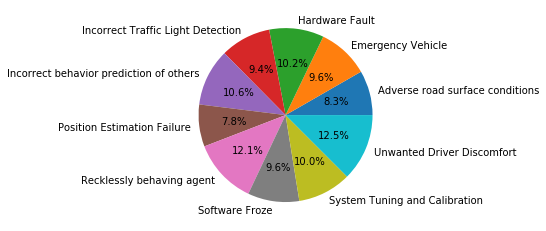

In [ ]:
Group_by_cause=disengagements.groupby("Cause").count()
Plot_Pie=plt.pie(Group_by_cause["Car"],labels=Group_by_cause.index,autopct='%1.1f%%')

In [ ]:
# list the top 2 leading causes of disengagement
Group_by_cause.sort_values(by=['Car'], ascending=False).index[:2]

Index(['Unwanted Driver Discomfort', 'Recklessly behaving agent'], dtype='object', name='Cause')

4. **Trend Visualization of disengagement/mile over time.**

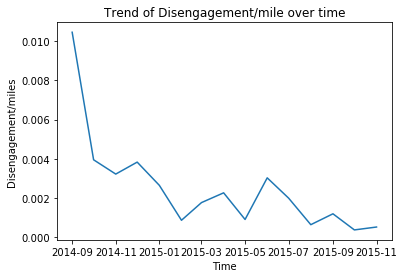

In [ ]:
# Visualize the trend of disengagement/mile over time
'Adding Date column in datetime format'
from datetime import date
from time import strptime
Date = []
for ym in totalmiles['Month']:
    y, m = ym.split('-')
    Date.append(date(int(y)+2000, strptime(m,"%b").tm_mon,1))

'Sorting data by Date'
totalmiles['Date'] = Date
Group_by_Month=totalmiles.groupby("Date").sum()
Group_by_Month.sort_index()

'Plot to visualize the trend of disengagement/mile over time'
plot_trend=plt.plot(Group_by_Month.index,(Group_by_Month["total number of disengagements"]/Group_by_Month["miles driven in autonomous mode"]))
plt.xlabel('Time');
plt.ylabel('Disengagement/miles');
plt.title('Trend of Disengagement/mile over time');

From the above plot, it is clear that the disengagement per mile are decreasing over time which means AVs are maturing over time. However, after certain time period, the muturity rate slowed down.

### Basic Analysis of AV Disengagements

**Probability distribution of reaction times**

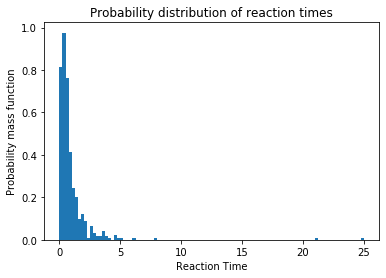

In [ ]:
Dropna_disengagement = disengagements.dropna()
hist = Dropna_disengagement.hist(column='ReactionTime', grid=False, bins=100, density = True)
plt.xlabel('Reaction Time');
plt.ylabel('Probability mass function');
plt.title('Probability distribution of reaction times');

**Compute the average reaction time**

In [ ]:
# For the entire duration of the dataset
disengagements['ReactionTime'].mean(skipna=True)

0.9297703252032521

In [ ]:
# For the entire duration of the dataset differentiated by the location of disengagement
Group_by_location=disengagements.groupby("Location").mean()
Group_by_location

,ReactionTime
Location,
highway,1.48000
urban-street,0.92865


4. **Hypothesis testing at a 0.05 significance level**\
Null Hypothesis: $H_0: \mu_{AV} = \mu_{non-AV} = 1.09$\
Alternate Hypothesis: $H_a: \mu_{AV} \ne \mu_{non-AV} \ne 1.09$

In [ ]:
from scipy.stats import ttest_1samp 
tset, pval = ttest_1samp(Dropna_disengagement.ReactionTime[disengagements['TypeOfTrigger'] == 'automatic'], 1.09)
tset, pval

(-2.0856358487615014, 0.0375284153714078)

In [ ]:
if pval < 0.05:    # significance level alpha = 0.05
    print("Rejecting null hypothesis")
else:
    print("Accepting null hypothesis")

Rejecting null hypothesis


In [ ]:
from statsmodels.stats import weightstats as stests
ztest, pval = stests.ztest(Dropna_disengagement.ReactionTime[disengagements['TypeOfTrigger'] == 'automatic'], x2 =None, value= 1.09)
ztest, pval

(-2.0856358487615014, 0.037011621483563954)

In [ ]:
if pval < 0.05:    # significance level alpha = 0.05
    print("Rejecting null hypothesis")
else:
    print("Accepting null hypothesis")

Rejecting null hypothesis


**Probability distribution of disengagements/mile. Distribution significance**

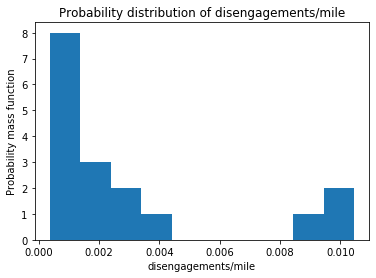

In [ ]:
totalmiles['disengagements/mile'] = totalmiles["total number of disengagements"]/totalmiles['miles driven in autonomous mode']
hist = totalmiles.hist(column='disengagements/mile', grid=False, bins=10)
plt.xlabel('disengagements/mile');
plt.ylabel('Probability mass function');
plt.title('Probability distribution of disengagements/mile');

###  Probabilistic Analysis of AV Disengagement

Asumptions for analysis:
1. There can be at most one disengagement in a mile
2. A day can be either clear or cloudy, but not both. The probability of a day being clear in California is 72%.
3. The AV is equally likely to drive on a cloudy day as on a clear day.

- The assumption on maximum number of disengagements in a mile allows to treat the occurrence of a disengagement in a mile as a random variable with a **binomial** distribution.

- The probability of disengagement per mile on a cloudy day and on a clear day

In [ ]:
# Probability for clear day = 0.72
P_CLEAR_DAY = 0.72

# Probability for AV driving on clear days = cloudy days = 0.5
P_AV_DRIVE_GIVEN_CLEAR_DAY = P_AV_DRIVE_GIVEN_CLOUDY_DAY = 0.5

# Total miles driven
miles_driven_auto_mode = np.sum(totalmiles['miles driven in autonomous mode'])

# Miles driven on clear and cloudy days
miles_driven_clear_day = P_CLEAR_DAY * miles_driven_auto_mode
miles_driven_cloudy_day = (1 - P_CLEAR_DAY) * miles_driven_auto_mode

# Total disengagements on clear and cloudy days
cloudy_disengagements = disengagements.Weather[disengagements['Weather'] == 'cloudy'].count()
clear_disengagements = disengagements.Weather[disengagements['Weather'] == 'clear'].count()

# Total disengagements
total_disengagements = np.sum(totalmiles['total number of disengagements'])

# P(AV disengaged/mile and ____ day) = Total disengagements on ____ days/Miles driven on ____ days'
P_disengaged_mile_cloudy_day = cloudy_disengagements/miles_driven_cloudy_day
P_disengaged_mile_clear_day = clear_disengagements/miles_driven_clear_day

P_disengaged_mile_cloudy_day, P_disengaged_mile_clear_day

(0.005902556775527249, 0.0005195663748517998)

- The probability of automatic disengagement per mile on a cloudy day and on a clear day

In [ ]:
# Total disengagements on clear and cloudy days with automatic types of trigger 
cloudy_auto_disengagements = disengagements.Weather[disengagements['Weather'] == 'cloudy'][disengagements['TypeOfTrigger'] == 'automatic'].count()
clear_auto_disengagements = disengagements.Weather[disengagements['Weather'] == 'clear'][disengagements['TypeOfTrigger'] == 'automatic'].count()

# P(auto disengaged/mile and ____ day) = Total auto disengagements on ____ days/Miles driven on ____ days'
P_auto_disengaged_mile_cloudy_day = cloudy_auto_disengagements/(miles_driven_cloudy_day)
P_auto_disengaged_mile_clear_day = clear_auto_disengagements/(miles_driven_clear_day)

P_auto_disengaged_mile_cloudy_day, P_auto_disengaged_mile_clear_day

(0.0028063653172267283, 0.00026390673008345393)

- How likely is it that in 12000 miles, there are 150 or more disengagements under cloudy conditions?

150 or more disengagement in 12000 miles is equivalent to 1 or more disenagements in 80 miles under cloudy conditions

$P_{12000}(k \ge 150) \approx P_{80}(k \ge 1) = 1 - P_{80}(k = 0)$\
$= 1 - \binom{n}{0} p^0 (1-p)^{(80-0)} = 1 - (1 - p)^{80} $

In [ ]:
P_12000_150 = 1 - (1-P_disengaged_mile_cloudy_day)**(80)
P_12000_150

0.3772459723827064

**At a 0.05 significance level, testing the following hypothesis: The AV has more disengagements (automatic and manual) on cloudy days than clear days. Based on the result of the hypothesis test, what can you conclude about the impact of weather conditions on AV safety?**

In [ ]:
'NULL      : P_disengagement_mile_clear_day - P_disengaged_mile_cloudy_day >= 0'
'ALTERNATE : P_disengagement_mile_clear_day - P_disengaged_mile_cloudy_day <  0'

# P(disengaged/mile) = Total disengagements/Total Miles
P_disenagements_per_mile = total_disengagements/miles_driven_auto_mode
Z = (P_disengaged_mile_clear_day - P_disengaged_mile_cloudy_day)/(P_disenagements_per_mile*(1-P_disenagements_per_mile)*((1/cloudy_disengagements)+(1/clear_disengagements)))**0.5

# Z(p-value<0.05) = -1.645
if Z < (-1.645):
    print('Fail to reject Null Hypothesis')
else:
    print('Reject Null Hypothesis')

Reject Null Hypothesis


This means there are high chances of disengagements per mile in cloudy than clear weather condition at 0.05 significance level. It is unsafe to drive AV in cloudy weather than clear weather condition.

**The conditional probability that the reaction time is:** \
a. **Greater than 0.6s given that the weather was cloudy? Reaction time is measured only in cases where there was an automatic disengagement.**\
b. **Greater than 0.9s given the weather was clear? Reaction time is measured only in cases where there was an automatic disengagement.**

In [ ]:
# Dataframe for all the disenagements on ______ days and automatic type of trigger
cloudy_dis_auto_df = disengagements[(disengagements['Weather'] == 'cloudy')
                                    & (disengagements['TypeOfTrigger'] == 'automatic')]
clear_dis_auto_df = disengagements[(disengagements['Weather'] == 'clear') 
                                   & (disengagements['TypeOfTrigger'] == 'automatic')]

# Dataframe for all the disenagements on cloudy/clear days and automatic type of trigger when reaction time greater than 0.6/0.9
cloudy_dis_auto_df_06 = cloudy_dis_auto_df[cloudy_dis_auto_df['ReactionTime'] > 0.6]
clear_dis_auto_df_09 = clear_dis_auto_df[clear_dis_auto_df['ReactionTime'] > 0.9]

# Probabilities of auto dis on rt > 0.6/0.9 for cloudy/clear
prob_cloudy_dis_auto_06 = len(cloudy_dis_auto_df_06)/len(cloudy_dis_auto_df)
prob_clear_dis_auto_09 = len(clear_dis_auto_df_09)/len(clear_dis_auto_df)

prob_cloudy_dis_auto_06, prob_clear_dis_auto_09

(0.473551637279597, 0.28125)

**A study found that an automatic AV disengagement will result in an accident if the human driver is slow in reacting. Following reactions are considered slow:**\
**(i) a reaction time greater than 0.6s under cloudy conditions and,**\
**(ii) a reaction time greater than 0.9s under clear conditions. Finding the probability of an accident per mile involving an AV disengagement.**

In [ ]:
# Prob(Accident|Disengaged) = P((Accident|disengaged)|cloudy) * P(cloudy) + P((Accident|disengaged)|clear) * P(clear)
(prob_cloudy_dis_auto_06 * 0.28) + (prob_clear_dis_auto_09 * 0.72)

0.3350944584382871

**The probability of a human driver causing a car accident is $2\times 10^{-6}$ [4]. Comparing AVs to human drivers?**

In [ ]:
# Prob(Accident) = Total disengagements on accident condition/total miles driven
"{:e}".format((len(cloudy_dis_auto_df_06)+len(clear_dis_auto_df_09))/miles_driven_auto_mode)

'4.255496e-04'

The probability of AVs causing accident is $4.25 \times 10^{-4}$ which is around 100 times the probability of human driver causing a car accident. This means, AVs are more susceptible than human driver to cause a car accident. 

In [ ]:
from scipy.stats import ks_2samp as ks

# Reaction time when cloudy/clear day
cloudy_rt = disengagements.ReactionTime[disengagements['Weather'] == 'cloudy'][disengagements['TypeOfTrigger'] == 'automatic']
clear_rt = disengagements.ReactionTime[disengagements['Weather'] == 'clear'][disengagements['TypeOfTrigger'] == 'automatic']

ks(cloudy_rt, clear_rt)

Ks_2sampResult(statistic=0.05622900923593619, pvalue=0.9534988141679469)

Null:      Both the distributions are same\
Alternate: Both the distributions are different

Since the K-S statistic is small and the p-value is high, we fail to reject null hypothesis. That means both the samples follows same distribution.

Even though, the both cloudy and clear reaction times are from same distribution, we cannot say anything about the impact of weather conditions on disengagement reaction time. However, if we can calculate the Z statistics that whether the mean of cloudy reaction time is equal to the mean of clear reaction time or not. This means the null and alternate hypothesis will be:\
Null Hypothesis      : $\mu_{cloudy\_rt} = \mu_{clear\_rt}$\
Alterante Hypothesis : $\mu_{cloudy\_rt} \ne \mu_{clear\_rt}$

### Using the Naive Bayes Model

**Though there are 10 different causes for disengagement, they can be grouped into the following 3 classes – (i) Controller, (ii) Perception System, and (iii) Computer System.**

In [ ]:
# Adding 'Class' column in the dataframe
disengagements['Class'] = ''
disengagements.loc[(disengagements['Cause'] == 'Incorrect behavior prediction of others') |
                   (disengagements['Cause'] == 'Recklessly behaving agent') |
                   (disengagements['Cause'] == 'Unwanted Driver Discomfort'),'Class'] = 'Controller'

disengagements.loc[(disengagements['Cause'] == 'Adverse road surface conditions') |
                   (disengagements['Cause'] == 'Emergency Vehicle') |
                   (disengagements['Cause'] == 'Position Estimation Failure') |
                   (disengagements['Cause'] == 'Incorrect Traffic Light Detection'),'Class'] = 'Perception System'

disengagements.loc[(disengagements['Cause'] == 'System Tuning and Calibration') |
                   (disengagements['Cause'] == 'Hardware Fault') |
                   (disengagements['Cause'] == 'Software Froze'),'Class'] = 'Computer System'

disengagements.head();

**Split the data randomly into training and testing (80-20 split). Using the fields ‘Location’, ‘Weather’, and ‘TypeOfTrigger’ as features and use ‘Class’ as the label.**

In [ ]:
# Creating random index between 0 to 1023 for 80-20 data split
Train_Index_List = []
Test_Index_List  = []
for i in range(1,6):
    np.random.seed(i)
    tot = list(np.arange(0,1024,1))
    np.random.shuffle(tot)
    train = tot[:820]
    test = [x for x in tot if x not in train]
    Train_Index_List.append(train)
    Test_Index_List.append(test)

In [ ]:
# Created a new data frame with required columns for Naive Bayes Model development
NB_disengagement = disengagements[['Location','Weather','TypeOfTrigger','Class']]

**Creating a NB model to identify the cause of disengagement based on the features ‘Location’, ‘Weather’, and ‘TypeOfTrigger’.**

In [ ]:
# Created a new dataframe for first train split from randomly generated indices
train1 = Train_Index_List[0]
test1  = Test_Index_List[0]
NB_train = NB_disengagement.iloc[train1,:]
NB_train.head()

,Location,Weather,TypeOfTrigger,Class
830,urban-street,cloudy,manual,Perception System
795,urban-street,cloudy,automatic,Controller
495,urban-street,clear,automatic,Computer System
822,urban-street,cloudy,automatic,Perception System
859,urban-street,cloudy,automatic,Perception System


In [ ]:
# Pivot table for each features vs Class to determine conditional probability table
NB_train_Location = NB_train.pivot_table(index='Class', columns='Location', aggfunc='size', fill_value=0)
NB_train_Weather = NB_train.pivot_table(index='Class', columns='Weather', aggfunc='size', fill_value=0)
NB_train_TypeOfTrigger = NB_train.pivot_table(index='Class', columns='TypeOfTrigger', aggfunc='size', fill_value=0)

NB_train_Location

Location,highway,urban-street
Class,,
Computer System,17,229
Controller,0,300
Perception System,0,274


In [ ]:
 NB_train_Weather

Weather,clear,cloudy
Class,,
Computer System,152,94
Controller,1,299
Perception System,0,274


In [ ]:
NB_train_TypeOfTrigger

TypeOfTrigger,automatic,manual
Class,,
Computer System,119,127
Controller,34,266
Perception System,228,46


In [ ]:
# Calculating and creating a dataframe for storing conditional probability table
Prior_NB_Train = pd.DataFrame(NB_train_Location.sum(axis=1)/NB_train_Location.sum().sum(), columns = ['Class'])
Prior_NB_Train['highway'] = NB_train_Location['highway'].values/NB_train_Location.sum(axis=1)
Prior_NB_Train['urban-street'] = NB_train_Location['urban-street'].values/NB_train_Location.sum(axis=1)

Prior_NB_Train['clear'] = NB_train_Weather['clear'].values/NB_train_Weather.sum(axis=1)
Prior_NB_Train['cloudy'] = NB_train_Weather['cloudy'].values/NB_train_Weather.sum(axis=1)

Prior_NB_Train['automatic'] = NB_train_TypeOfTrigger['automatic'].values/NB_train_TypeOfTrigger.sum(axis=1)
Prior_NB_Train['manual'] = NB_train_TypeOfTrigger['manual'].values/NB_train_TypeOfTrigger.sum(axis=1)
Prior_NB_Train.index = NB_train_TypeOfTrigger.index
Prior_NB_Train.columns = pd.MultiIndex(levels=[['','Location', 'Weather', 'TypeOfTrigger'], 
                                               ['Class','highway','urban-street','clear','cloudy','automatic','manual']], 
                                       codes= [[0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 3, 4, 5, 6]])
Prior_NB_Train

Location                Weather            \
                      Class   highway urban-street     clear    cloudy   
Class                                                                    
Computer System    0.300000  0.069106     0.930894  0.617886  0.382114   
Controller         0.365854  0.000000     1.000000  0.003333  0.996667   
Perception System  0.334146  0.000000     1.000000  0.000000  1.000000   

                  TypeOfTrigger            
                      automatic    manual  
Class                                      
Computer System        0.483740  0.516260  
Controller             0.113333  0.886667  
Perception System      0.832117  0.167883

In [ ]:
# User-defined function for Naive Bayes Model
def NB_Model(Input_list, df):
    P = pd.DataFrame(df.loc[:,('','Class')].values * df.loc[:, ('Location',Input_list[0])].values * df.loc[:, ('Weather',Input_list[1])].values * df.loc[:, ('TypeOfTrigger',Input_list[2])].values,
                     index=df.index, columns=['Probability'])
    return P[P['Probability'] == max(P['Probability'])].index[0]

# Testing Naive Bayes Model for specific set of features
NB_Model(['urban-street', 'cloudy', 'manual'],df = Prior_NB_Train)

'Controller'

**Using the model to predict the cause of the disengagement for the test dataset. Computing the accuracy achieved by model.**

In [ ]:
# Created a new dataframe for first test split from randomly generated indices
NB_test = NB_disengagement.iloc[test1,:]
NB_test.head()

,Location,Weather,TypeOfTrigger,Class
646,urban-street,cloudy,manual,Controller
811,urban-street,cloudy,manual,Perception System
628,urban-street,cloudy,manual,Controller
212,urban-street,cloudy,manual,Controller
984,urban-street,cloudy,manual,Controller


In [ ]:
# Overall accuracy of NB model generated from train1 and tested on test1
NB_test['Predicted Class'] = [NB_Model(NB_test.iloc[i,:3].values,df=Prior_NB_Train) for i in range(len(NB_test))]
(NB_test["Class"]==NB_test["Predicted Class"]).value_counts(normalize=True)[1]

0.7598039215686274

In [ ]:
# Generating Confusion Matrix for NB model tested on test1
df_confusion = pd.crosstab(NB_test["Class"], NB_test["Predicted Class"])
df_confusion['Predicted Accuracy'] = np.diag(df_confusion)/df_confusion.sum(axis=1)
df_confusion.columns = pd.Index(['CS', 'C', 'PS', 'Predicted Accuracy'],
                                dtype='object', name='Predicted Class')
df_confusion.index = pd.Index(['CS', 'C', 'PS'],
                                dtype='object', name='Actual Class')
df_confusion

Predicted Class,CS,C,PS,Predicted Accuracy
Actual Class,,,,
CS,38,11,9,0.655172
C,0,47,14,0.770492
PS,0,15,70,0.823529


**Getting a better estimate of the model performance, perform cross-validation.**

In [ ]:
# Running NB model on 5 random 80-20 split data and recording confusion matrix and accuracy
Accuracy = []
Confusion_Matrix_List = []
for train, test in zip(Train_Index_List, Test_Index_List):
    
    NB_train = NB_disengagement.iloc[train,:]
    NB_test = NB_disengagement.iloc[test,:]
    
    NB_train_Location = NB_train.pivot_table(index='Class', columns='Location', aggfunc='size', fill_value=0)
    NB_train_Weather = NB_train.pivot_table(index='Class', columns='Weather', aggfunc='size', fill_value=0)
    NB_train_TypeOfTrigger = NB_train.pivot_table(index='Class', columns='TypeOfTrigger', aggfunc='size', fill_value=0)
    
    Prior_NB_Train = pd.DataFrame(NB_train_Location.sum(axis=1)/NB_train_Location.sum().sum(), columns = ['Class'])
    Prior_NB_Train['highway'] = NB_train_Location['highway'].values/NB_train_Location.sum(axis=1)
    Prior_NB_Train['urban-street'] = NB_train_Location['urban-street'].values/NB_train_Location.sum(axis=1)

    Prior_NB_Train['clear'] = NB_train_Weather['clear'].values/NB_train_Weather.sum(axis=1)
    Prior_NB_Train['cloudy'] = NB_train_Weather['cloudy'].values/NB_train_Weather.sum(axis=1)

    Prior_NB_Train['automatic'] = NB_train_TypeOfTrigger['automatic'].values/NB_train_TypeOfTrigger.sum(axis=1)
    Prior_NB_Train['manual'] = NB_train_TypeOfTrigger['manual'].values/NB_train_TypeOfTrigger.sum(axis=1)
    Prior_NB_Train.index = NB_train_TypeOfTrigger.index
    
    Prior_NB_Train.columns = pd.MultiIndex(levels=[['','Location', 'Weather', 'TypeOfTrigger'], 
                                                   ['Class','highway','urban-street','clear','cloudy','automatic','manual']], 
                                           codes= [[0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 3, 4, 5, 6]])

    
    NB_test['Predicted Class'] = [NB_Model(NB_test.iloc[i,:3].values,df=Prior_NB_Train) for i in range(len(NB_test))]
    
    Accuracy.append((NB_test["Class"]==NB_test["Predicted Class"]).value_counts(normalize=True)[1])
    
    df_confusion = pd.crosstab(NB_test["Class"], NB_test["Predicted Class"])
    df_confusion['Predicted Accuracy'] = np.diag(df_confusion)/df_confusion.sum(axis=1)
    df_confusion.columns = pd.Index(['CS', 'C', 'PS', 'Predicted Accuracy'],
                                dtype='object', name='Predicted Class')
    df_confusion.index = pd.Index(['CS', 'C', 'PS'],
                                dtype='object', name='Actual Class')
    
    Confusion_Matrix_List.append(df_confusion)    

In [ ]:
# Confusion matrix and accuracy for all five training-testing sets
for C,A in zip(Confusion_Matrix_List, Accuracy):
    print(C)
    print('Total Accuracy =',A)
    print()

Predicted Class  CS   C  PS  Predicted Accuracy
Actual Class                                   
CS               38  11   9            0.655172
C                 0  47  14            0.770492
PS                0  15  70            0.823529
Total Accuracy = 0.7598039215686274

Predicted Class  CS   C  PS  Predicted Accuracy
Actual Class                                   
CS               43  10  11            0.671875
C                 0  58   6            0.906250
PS                0  13  63            0.828947
Total Accuracy = 0.803921568627451

Predicted Class  CS   C  PS  Predicted Accuracy
Actual Class                                   
CS               40  12  13            0.615385
C                 0  72   8            0.900000
PS                0  11  48            0.813559
Total Accuracy = 0.7843137254901961

Predicted Class  CS   C  PS  Predicted Accuracy
Actual Class                                   
CS               47   9   8            0.734375
C                 0  65   

In [ ]:
# Average accuracy from all five training-testing sets
"{:0.2f}%".format(np.mean(Accuracy)*100)

'79.61%'


NB model is doing great. The average accuracy is almost 80%, which is far better than chance. Since earlier before creating naive bayes model, P(Class = Computer System) ~ 0.287, P(Class = Controller) ~  0.3609, P(Class = Preception System) ~ 0.3512. Based on these probability, the probability of controller class was higher. This mean the accuracy of model was 36.09%. However, now with NB model, the accuracy improved to 80% (approx).

All the features i.e., location, weather and type of trigger are conditionally independent. This assumption may not be realistic since there might be some relationship between type of trigger vs weather condition and type of trigger vs location; since, there are high chances of disengagements per mile in urban-street than highway and during cloudy than clear weather condition.

Since, we made an assumption about independency of the features, which might not be completely right. We might be able to improve the accuracy of the model by taking the dependency among the features into account using Bayesian Network. 
